In [47]:
# ! pip install -U pip setuptools wheel
# ! pip install -U spacy[cuda113]

  Using cached cupy_cuda113-10.6.0-cp310-cp310-win_amd64.whl (56.7 MB)


In [48]:
# ! python -m spacy download en_core_web_trf

     ------------------------------------- 460.3/460.3 MB 11.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


c:\Users\kes\AppData\Local\Programs\Python\Python310\lib\site-packages\cupy\_environment.py:437: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda112, cupy-cuda113

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [49]:
# ! pip install sentence_transformers

In [50]:
# ! pip install transformers -q
# ! pip install simpletransformers wandb pytorch-lightning
# ! pip install -U transformers torch sentencepiece
# ! pip install -U summa

  Using cached transformers-4.24.0-py3-none-any.whl (5.5 MB)
  Using cached torch-1.13.0-cp310-cp310-win_amd64.whl (167.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu116
    Uninstalling torch-1.12.1+cu116:
      Successfully uninstalled torch-1.12.1+cu116


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\kes\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [51]:
import spacy
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

import string

import gensim
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# ! conda install -c conda-forge sentence-transformers

from sentence_transformers import SentenceTransformer

from gensim.models import Word2Vec

# ! pip install transformers -q
# ! pip install simpletransformers wandb pytorch-lightning
# ! pip install -U transformers torch sentencepiece
# ! pip install -U summa


# $\textbf{All Pre-processing Functions on Top}$

In [53]:
def read_data(path):
    df = pd.read_pickle(path,compression = 'zstd')
    df = df.dropna(how="any")
    return df

# def tokenize_and_remove_stopwords(X):
#     stop_words = set(stopwords.words('english'))
#     return X['tokens'].apply(lambda x: [word for word in x if word not in stop_words])


def preprocess(df):

    def remove_space(match_obj):
        if match_obj.group() is not None:
            return match_obj.group().replace(' ','|')

    df['Text'] = df['Text'].str.replace(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?', 'URL', regex=True)


    # remove '|' so we can use it as a unique space seperator for cases
    df['Text'] = df['Text'].str.replace(r'|', '', regex=True)


    df['Text'] = df['Text'].str.replace(r'U\. S\. C\.', 'U.S.C.', regex=True)
    df['Text'] = df['Text'].str.replace(r'U\. S\.', 'U.S.', regex=True)
    df['Text'] = df['Text'].str.replace(r'No\. ', 'No.', regex=True)
    r"F\.( \d+-?\w*,?)+( \([A-Z]*\d* ?\d*\),?)*"
    # df['Text'] = df['Text'].str.replace(r"F\.( \d+-?\w*,?)+( \([A-Z]*\d* ?\d*\),?)*", remove_space, regex=True)
    text = []
    for element in df['Text']:
        element = re.sub(r"\bF\.( \d+-?\w*,?)+( \([A-Z]*\d* ?\d*\),?)*", remove_space, element)
        element = re.sub(r"\b(\d+ )?U\.S\.C\. [A-Z]+\d*", remove_space, element)
        element = re.sub(r"\b(\d+ )?U\.S\.(( |-)\(?\d+,?\)?)+", remove_space, element)
        element = re.sub(r"\bArt\. [A-Z]+,?( [A-Z]\d+)?", remove_space, element)
        element = re.sub(r"\b\d{4} [A-Z]+ \d+,?( \*\d*)?", remove_space, element)
        element = re.sub(r"\bn\.( \d+)+( \(.+?\))?", remove_space, element)
        element = re.sub(r"\bPp\. [0-9\-]+", remove_space, element)
        # element = re.sub(r"\b([A-Z]+[a-z]*[A-Z\.']+,? )+v\.( [A-Z]+[a-z]*[A-Z\.']+,?)+ ?", remove_space, element)
        element = re.sub(r"\b\d+ U\.S.[_,\- ]*\(\d+\)", remove_space, element)
        element = re.sub(r"([A-Z0-9]+\S+)( (([A-Z0-9]+\S+)|(at)))+(( \(\d+\))|(?! [A-Z]?[a-z]+))(?![A-Z]?[a-z]+)", remove_space, element)
        text.append(element)
    df['Text'] = text
    # Disabled as legal cases need punctuations to work
    # # remove non-alphabetical
    # df['Text'] = df['Text'].str.replace('[^a-zA-Z0-9\'\".!()]', ' ', regex=True).str.strip()


    # remove extra spaces
    df['Text'] = df['Text'].str.replace(' +', ' ', regex=True).str.strip()


    return df

def process_VS_data(df):

    #assert tokens column is present
    assert 'tokens' in df.columns

    new_tokens = []
    for case in df['tokens']:
        new_token = []
        case_found = False
        for tokenIdx in range(len(case)):
            new_token.append(case[tokenIdx])
            # Handling cases
            #United States v. Rostenkowski, 59 F. 3d 1291, 1297 (CADC 1995).
            #United States Supreme Court AARON J. SCHOCK v. UNITED STATES(2019) No. 18-406
            if case[tokenIdx] == 'v.':
                case_found = True
            elif case_found and (case[tokenIdx].startswith('No.') or case[tokenIdx][0].islower() or case[tokenIdx][0].isnumeric() or case[tokenIdx-1].lower().startswith('al.')):
                # we need to deal with this
                last_word = new_token.pop()
                castStr = ''
                while len(new_token) > 0 and (new_token[-1] == 'v.' or (new_token[-1].lower() != 'see' and new_token[-1][0].isupper())) :
                    castStr =  new_token.pop() + '|' + castStr
                new_token.append(castStr[:-1])
                case_found = False
                new_token.append(last_word)
        new_tokens.append(new_token)
    df['tokens'] = new_tokens

    # change all tokens to lower case
    # df['tokens'] = df['tokens'].apply(lambda x: [item.lower() for item in x])

    return df


In [54]:
# # read data
# path = 'data/all_year.pkl.zst'
# df = read_data(path)

In [55]:
# read data
path = 'data/2021.pkl.zst'
df = read_data(path)

## Pre-processing here

In [56]:
df = preprocess(df)
#split the processed text into tokens for further processing with pipes | as the combinator
df['tokens'] = df['Text'].str.split() 
df['tokens'] = process_VS_data(df)['tokens']
df['Text'] = df['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
print(df['Text'][0])

In [58]:
#apply nlp to the new text
df['nlp'] = df['Text'].apply(lambda x: nlp(x))
df['nlp']

0      (United|States|Supreme|Court|FEDERAL|COMMUNICA...
1      (United|States|Supreme|Court|AGENCY|FOR|INTERN...
2      (United|States|Supreme|Court|ALLEN|ET|AL.|v.|C...
3      (United|States|Supreme|Court|AMERICANS|FOR|PRO...
4      (United|States|Supreme|Court|AMG|CAPITAL|MANAG...
                             ...                        
134    (United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...
135    (United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...
136    (United|States|Supreme|Court|WILLIAM|P.|BARR,|...
137    (United|States|Supreme|Court|WILLIAM|P.|BARR,|...
138    (United|States|Supreme|Court|YELLEN,|SECRETARY...
Name: nlp, Length: 139, dtype: object

In [ ]:
df['nlp'][0]

In [60]:

#for each nlp object, get lemma and pos
df['lemma'] = df['nlp'].apply(lambda x: [token.lemma_ for token in x])
# remove punctuations from lemma
df['lemma'] = df['lemma'].apply(lambda x: [token for token in x if token not in string.punctuation])
# create a new column and convert lemma to string
df['final_text'] = df['lemma'].apply(lambda x: ' '.join(x))
# remove '\'s' from final_text
df['final_text'] = df['final_text'].str.replace(r'\'s', '', regex=True)

In [ ]:
df['final_text'][0]

In [ ]:
df['lemma'][0]

In [63]:
df

,Title,Docket,Argued,Decided,Text,tokens,nlp,lemma,final_text
0,FEDERAL COMMUNICATIONS COMMISSION ET AL. v. PR...,No. 19-1231,"January 19, 2021","April 1, 2021",United|States|Supreme|Court|FEDERAL|COMMUNICAT...,[United|States|Supreme|Court|FEDERAL|COMMUNICA...,(United|States|Supreme|Court|FEDERAL|COMMUNICA...,[United|States|Supreme|Court|FEDERAL|COMMUNICA...,United|States|Supreme|Court|FEDERAL|COMMUNICAT...
1,AGENCY FOR INTERNATIONAL DEVELOPMENT ET AL. v....,No. 19-177,"May 5, 2020","June 29, 2020",United|States|Supreme|Court|AGENCY|FOR|INTERNA...,[United|States|Supreme|Court|AGENCY|FOR|INTERN...,(United|States|Supreme|Court|AGENCY|FOR|INTERN...,[United|States|Supreme|Court|AGENCY|FOR|INTERN...,United|States|Supreme|Court|AGENCY|FOR|INTERNA...
2,"ALLEN ET AL. v. COOPER, GOVERNOR OF NORTH CARO...",No. 18-877,"November 5, 2019","March 23, 2020",United|States|Supreme|Court|ALLEN|ET|AL.|v.|CO...,[United|States|Supreme|Court|ALLEN|ET|AL.|v.|C...,(United|States|Supreme|Court|ALLEN|ET|AL.|v.|C...,[united|states|supreme|court|allen|et|al.|v.|c...,united|states|supreme|court|allen|et|al.|v.|co...
3,"AMERICANS FOR PROSPERITY FOUNDATION v. BONTA, ...",No. 19-251,"April 26, 2021","July 1, 2021",United|States|Supreme|Court|AMERICANS|FOR|PROS...,[United|States|Supreme|Court|AMERICANS|FOR|PRO...,(United|States|Supreme|Court|AMERICANS|FOR|PRO...,[united|states|supreme|court|americans|for|pro...,united|states|supreme|court|americans|for|pros...
4,"AMG CAPITAL MANAGEMENT, LLC, ET AL. v. FEDERAL...",No. 19-508,"January 13, 2021","April 22, 2021",United|States|Supreme|Court|AMG|CAPITAL|MANAGE...,[United|States|Supreme|Court|AMG|CAPITAL|MANAG...,(United|States|Supreme|Court|AMG|CAPITAL|MANAG...,[United|States|Supreme|Court|AMG|CAPITAL|MANAG...,United|States|Supreme|Court|AMG|CAPITAL|MANAGE...
...,...,...,...,...,...,...,...,...,...
134,"WHOLE WOMAN'S HEALTH ET AL. v. JACKSON, JUDGE,...",No. 21-463,"November 1, 2021","December 10, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,[United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,(United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,[United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...
135,WHOLE WOMAN'S HEALTH ET AL. v. AUSTIN REEVE ...,No. 21a24,,"September 1, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,[United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,(United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,[united|states|supreme|court|whole|woman's|hea...,united|states|supreme|court|whole|woman|health...
136,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a8,,"July 14, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","[United|States|Supreme|Court|WILLIAM|P.|BARR,|...","(United|States|Supreme|Court|WILLIAM|P.|BARR,|...","[united|states|supreme|court|william|p.|barr,|...","united|states|supreme|court|william|p.|barr,|a..."
137,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a9,,"July 16, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","[United|States|Supreme|Court|WILLIAM|P.|BARR,|...","(United|States|Supreme|Court|WILLIAM|P.|BARR,|...","[united|states|supreme|court|william|p.|barr,|...","united|states|supreme|court|william|p.|barr,|a..."


In [64]:
del df['lemma']
del df['nlp']

In [65]:
df

,Title,Docket,Argued,Decided,Text,tokens,final_text
0,FEDERAL COMMUNICATIONS COMMISSION ET AL. v. PR...,No. 19-1231,"January 19, 2021","April 1, 2021",United|States|Supreme|Court|FEDERAL|COMMUNICAT...,[United|States|Supreme|Court|FEDERAL|COMMUNICA...,United|States|Supreme|Court|FEDERAL|COMMUNICAT...
1,AGENCY FOR INTERNATIONAL DEVELOPMENT ET AL. v....,No. 19-177,"May 5, 2020","June 29, 2020",United|States|Supreme|Court|AGENCY|FOR|INTERNA...,[United|States|Supreme|Court|AGENCY|FOR|INTERN...,United|States|Supreme|Court|AGENCY|FOR|INTERNA...
2,"ALLEN ET AL. v. COOPER, GOVERNOR OF NORTH CARO...",No. 18-877,"November 5, 2019","March 23, 2020",United|States|Supreme|Court|ALLEN|ET|AL.|v.|CO...,[United|States|Supreme|Court|ALLEN|ET|AL.|v.|C...,united|states|supreme|court|allen|et|al.|v.|co...
3,"AMERICANS FOR PROSPERITY FOUNDATION v. BONTA, ...",No. 19-251,"April 26, 2021","July 1, 2021",United|States|Supreme|Court|AMERICANS|FOR|PROS...,[United|States|Supreme|Court|AMERICANS|FOR|PRO...,united|states|supreme|court|americans|for|pros...
4,"AMG CAPITAL MANAGEMENT, LLC, ET AL. v. FEDERAL...",No. 19-508,"January 13, 2021","April 22, 2021",United|States|Supreme|Court|AMG|CAPITAL|MANAGE...,[United|States|Supreme|Court|AMG|CAPITAL|MANAG...,United|States|Supreme|Court|AMG|CAPITAL|MANAGE...
...,...,...,...,...,...,...,...
134,"WHOLE WOMAN'S HEALTH ET AL. v. JACKSON, JUDGE,...",No. 21-463,"November 1, 2021","December 10, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,[United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...
135,WHOLE WOMAN'S HEALTH ET AL. v. AUSTIN REEVE ...,No. 21a24,,"September 1, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,[United|States|Supreme|Court|WHOLE|WOMAN'S|HEA...,united|states|supreme|court|whole|woman|health...
136,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a8,,"July 14, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","[United|States|Supreme|Court|WILLIAM|P.|BARR,|...","united|states|supreme|court|william|p.|barr,|a..."
137,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a9,,"July 16, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","[United|States|Supreme|Court|WILLIAM|P.|BARR,|...","united|states|supreme|court|william|p.|barr,|a..."


In [66]:
# df['final_text'] = df['final_text'].str.replace('|',' ')

In [68]:
df['final_text']

0      United|States|Supreme|Court|FEDERAL|COMMUNICAT...
1      United|States|Supreme|Court|AGENCY|FOR|INTERNA...
2      united|states|supreme|court|allen|et|al.|v.|co...
3      united|states|supreme|court|americans|for|pros...
4      United|States|Supreme|Court|AMG|CAPITAL|MANAGE...
                             ...                        
134    United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...
135    united|states|supreme|court|whole|woman|health...
136    united|states|supreme|court|william|p.|barr,|a...
137    united|states|supreme|court|william|p.|barr,|a...
138    United|States|Supreme|Court|YELLEN,|SECRETARY|...
Name: final_text, Length: 139, dtype: object

In [69]:
df.to_csv('preprocessed_data.tsv.zst', index=False, sep='\t',compression='zstd')

In [2]:
df = pd.read_csv('preprocessed_data.tsv.zst', sep='\t',compression='zstd')

In [3]:
df

,Title,Docket,Argued,Decided,Text,tokens,final_text
0,FEDERAL COMMUNICATIONS COMMISSION ET AL. v. PR...,No. 19-1231,"January 19, 2021","April 1, 2021",United|States|Supreme|Court|FEDERAL|COMMUNICAT...,['United|States|Supreme|Court|FEDERAL|COMMUNIC...,United|States|Supreme|Court|FEDERAL|COMMUNICAT...
1,AGENCY FOR INTERNATIONAL DEVELOPMENT ET AL. v....,No. 19-177,"May 5, 2020","June 29, 2020",United|States|Supreme|Court|AGENCY|FOR|INTERNA...,['United|States|Supreme|Court|AGENCY|FOR|INTER...,United|States|Supreme|Court|AGENCY|FOR|INTERNA...
2,"ALLEN ET AL. v. COOPER, GOVERNOR OF NORTH CARO...",No. 18-877,"November 5, 2019","March 23, 2020",United|States|Supreme|Court|ALLEN|ET|AL.|v.|CO...,['United|States|Supreme|Court|ALLEN|ET|AL.|v.|...,united|states|supreme|court|allen|et|al.|v.|co...
3,"AMERICANS FOR PROSPERITY FOUNDATION v. BONTA, ...",No. 19-251,"April 26, 2021","July 1, 2021",United|States|Supreme|Court|AMERICANS|FOR|PROS...,['United|States|Supreme|Court|AMERICANS|FOR|PR...,united|states|supreme|court|americans|for|pros...
4,"AMG CAPITAL MANAGEMENT, LLC, ET AL. v. FEDERAL...",No. 19-508,"January 13, 2021","April 22, 2021",United|States|Supreme|Court|AMG|CAPITAL|MANAGE...,['United|States|Supreme|Court|AMG|CAPITAL|MANA...,United|States|Supreme|Court|AMG|CAPITAL|MANAGE...
...,...,...,...,...,...,...,...
134,"WHOLE WOMAN'S HEALTH ET AL. v. JACKSON, JUDGE,...",No. 21-463,"November 1, 2021","December 10, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,"[""United|States|Supreme|Court|WHOLE|WOMAN'S|HE...",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...
135,WHOLE WOMAN'S HEALTH ET AL. v. AUSTIN REEVE ...,No. 21a24,NaN,"September 1, 2021",United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...,"[""United|States|Supreme|Court|WHOLE|WOMAN'S|HE...",united|states|supreme|court|whole|woman|health...
136,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a8,NaN,"July 14, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","['United|States|Supreme|Court|WILLIAM|P.|BARR,...","united|states|supreme|court|william|p.|barr,|a..."
137,"WILLIAM P. BARR, ATTORNEY GENERAL, ET AL. v. ...",No. 20a9,NaN,"July 16, 2020","United|States|Supreme|Court|WILLIAM|P.|BARR,|A...","['United|States|Supreme|Court|WILLIAM|P.|BARR,...","united|states|supreme|court|william|p.|barr,|a..."


# $\textbf{Text Summarization Functions}$

In [4]:
df["final_text"]

0      United|States|Supreme|Court|FEDERAL|COMMUNICAT...
1      United|States|Supreme|Court|AGENCY|FOR|INTERNA...
2      united|states|supreme|court|allen|et|al.|v.|co...
3      united|states|supreme|court|americans|for|pros...
4      United|States|Supreme|Court|AMG|CAPITAL|MANAGE...
                             ...                        
134    United|States|Supreme|Court|WHOLE|WOMAN'S|HEAL...
135    united|states|supreme|court|whole|woman|health...
136    united|states|supreme|court|william|p.|barr,|a...
137    united|states|supreme|court|william|p.|barr,|a...
138    United|States|Supreme|Court|YELLEN,|SECRETARY|...
Name: final_text, Length: 139, dtype: object

In [7]:
from transformers import pipeline


# summarizer = pipeline("summarization",model="sshleifer/distilbart-xsum-12-6",device=0)
# df["summary_pipeline"] = summarizer(df["Text"].tolist(), truncation=True, max_length=1024, min_length=64)




In [9]:
import summa

In [10]:
df["summary_summa"] = df["Text"].apply(lambda x: summa.summarizer.summarize(x, ratio=0.02))

In [47]:
df["summary_summa"][0]

'In analyzing whether to repeal or modify its existing ownership rules, the FCC considered the record evidence and reasonably concluded that the three ownership rules at issue were no longer necessary to serve the agency\'s public interest goals of competition, localism, and viewpoint diversity, and that the rule changes were not likely to harm minority and female ownership.\nIn conducting its public interest analysis under Section|202(h), the FCC considered the effects of the rules on competition, localism, viewpoint diversity, and minority and female ownership of broadcast media outlets.\nIn its quadrennial Section|202(h) order issued in 2016, the FCC concluded that the Newspaper/Broadcast|Cross-Ownership,|Radio/Television|Cross-Ownership, and Local Television Ownership Rules remained necessary to serve the agency\'s public interest goals of promoting "competition and a diversity of viewpoints in local markets." In re 2014|Quadrennial|Regulatory|Review--Second Report and Order,|31|FC

In [74]:
summarizer = pipeline("summarization",model="sshleifer/distilbart-xsum-12-6",device=0)

In [ ]:
df["final_text"][0]

In [76]:
summarizer(df["Text"][0], truncation=True, max_length=1024, min_length=64)[0]['summary_text']

" The US Supreme Court has ruled in the Prometheus Radio Project case against the Federal Communications Commission (FCC) over its decision to repeal or modify three of its media ownership rules in 2017, but ruled that the agency's decision was not arbitrary and capricious, and that the rule changes were likely to harm minority and female ownership"

In [77]:
summarizer(df["final_text"][0], truncation=True, max_length=1024, min_length=64)[0]['summary_text']

" Prometheus Radio Project and several other public interest and consumer advocacy groups have won their case at the US Supreme Court against the Federal Communications Commission (FCC) over a rule that limits the number of radio station and newspaper owners in a give-market given to a single entity in a given market, and the agency's decision to repeal or modify three ownership rule"

In [17]:
sums = summarizer(df["Text"].tolist(), truncation=True, max_length=1024, min_length=64)

In [18]:
sums

[{'summary_text': " The US Supreme Court has ruled in the Prometheus Radio Project case against the Federal Communications Commission (FCC) over its decision to repeal or modify three of its media ownership rules in 2017, but ruled that the agency's decision was not arbitrary and capricious, and that the rule changes were likely to harm minority and female ownership"},
 {'summary_text': " A federal agency's requirement that it funding foreign nongovernmental groups with a policy against prostitution and sex trafficking is not unconstitutional, the Supreme Court has ruled in a case brought by the Alliance for Open Society, a group representing open society, and a group of American-based non-governmental organisations. and foreign groups"},
 {'summary_text': " A federal court ruled in the case of Frederick Allen, a videographer who documented the recovery of a shipwreck off the North Carolina coast, that Congress did not have the power to abrogate the States' sovereign immunity from copy

In [20]:
df['summary_pipeline'] = [dic['summary_text'] for dic in sums]

In [82]:
cnnsummarizer = pipeline("summarization",device=0)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [84]:
cnnsummarizer(df["final_text"][0], truncation=True, max_length=1024, min_length=64)[0]['summary_text']

' Prometheus Radio Project and several other public interest and consumer advocacy group collectively petition for review . Prometheus argue that the FCC  decision to repeal or modify the three rule be arbitrary and capricious under the administrative .procedure . Act of 1996 direct the FCC to review its medium ownership rule every four year and to repeal . or modify any rule that no long serve the public interest . In 2017 the FCC concluded that three of its ownership rule be no long necessary to promote competition localism or viewpoint diversity .'

In [85]:
cnnsummarizer(df["Text"][0], truncation=True, max_length=1024, min_length=64)[0]['summary_text']

" The Federal Communications Commission possesses broad authority to regulate broadcast media in the public interest . In 2017, the FCC concluded that three of its ownership rules were no longer necessary to promote competition, localism, or viewpoint diversity . Prometheus Radio Project and several other public interest and consumer advocacy groups petitioned for review . The Third Circuit vacated the FCC's reconsideration order, holding that the record did not support the agency's conclusion that the rule changes would have minimal effect on minority ."

# $\textbf{Vectorization Functions}$

In [42]:
def concat_vectors(text_vector, transformer_vector, summa_vector):
    return np.concatenate((text_vector, transformer_vector, summa_vector), axis=0)

def combined_vectors(text_vec, transformer_vec, summa_vector):
    combined_vectors = list()
    print(transformer_vec.shape)
    for i in range(len(transformer_vec)):
        combined_vectors.append(concat_vectors(text_vec[i], transformer_vec[i], summa_vector[i]))

    combined_vectors = np.array(combined_vectors)
    return combined_vectors

## Doc2Vec

In [9]:
def tagged_document(list_of_list_of_words):
       for i, list_of_words in enumerate(list_of_list_of_words):
      		yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

def process_doc2vec_similarity(X,case_id):

	documents = list(tagged_document(X))
		
	model = gensim.models.doc2vec.Doc2Vec(documents, vector_size=300, window=11, min_count=10, epochs=30)

	base_vector = model.infer_vector(documents[case_id].words.split())

	vectors = []
	for i, document in enumerate(documents):

		# tokens = list(filter(lambda x: x in model.wv.vocab.keys(), document))
		vector = model.infer_vector(document.words.split())
		vectors.append(vector)

	scores = cosine_similarity([base_vector], vectors).flatten()

	# top 10 highest scores
	highest_score_indices = scores.argsort()[-5:][::-1]

	
	print(highest_score_indices)

	highest_score = 0
	highest_score_index = 0
	for i, score in enumerate(scores):
		if highest_score < score and i != case_id:
			highest_score = score
			highest_score_index = i

	most_similar_document = documents[highest_score_index]
	print("Most similar document by Doc2vec with the score:", highest_score, highest_score_index)
	return vectors


In [10]:
print("Doc2Vec")
print("Final Text")
text_vec = process_doc2vec_similarity(df['final_text'], 1)

print("Summary Pipeline")
transformer_vec = process_doc2vec_similarity(df['summary_pipeline'], 1)

print("Summary Summa")
summa_vector = process_doc2vec_similarity(df['summary_summa'], 1)

print("Concatenated Vectors")
doc2vec_vectors = combined_vectors(text_vec, transformer_vec, summa_vector)

print(doc2vec_vectors.shape)

Doc2Vec
Final Text
[1 0 7 9 3]
Most similar document by Doc2vec with the score: 0.9930905 0
Summary Pipeline
[5 4 9 0 7]
Most similar document by Doc2vec with the score: 0.9982727 5
Summary Summa
[ 2 12  1  5  6]
Most similar document by Doc2vec with the score: 0.99665934 2
Concatenated Vectors
(15, 900)


In [11]:
def doc2vec(df):
    def tagged_document(list_of_list_of_words):
        for i, list_of_words in enumerate(list_of_list_of_words):
                yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

    def process_doc2vec_similarity(X,case_id):

        documents = list(tagged_document(X))
            
        model = gensim.models.doc2vec.Doc2Vec(documents, vector_size=300, window=11, min_count=10, epochs=30)

        base_vector = model.infer_vector(documents[case_id].words.split())

        vectors = []
        for i, document in enumerate(documents):

            # tokens = list(filter(lambda x: x in model.wv.vocab.keys(), document))
            vector = model.infer_vector(document.words.split())
            vectors.append(vector)

        scores = cosine_similarity([base_vector], vectors).flatten()

        # top 10 highest scores
        highest_score_indices = scores.argsort()[-5:][::-1]

        
        print(highest_score_indices)

        highest_score = 0
        highest_score_index = 0
        for i, score in enumerate(scores):
            if highest_score < score and i != case_id:
                highest_score = score
                highest_score_index = i

        most_similar_document = documents[highest_score_index]
        print("Most similar document by Doc2vec with the score:", highest_score, highest_score_index)
        return vectors
    
    text_vec = process_doc2vec_similarity(df['final_text'], 1)
    transformer_vec = process_doc2vec_similarity(df['summary_pipeline'], 1)
    summa_vector = process_doc2vec_similarity(df['summary_summa'], 1)

    doc2vec_vectors = combined_vectors(text_vec, transformer_vec, summa_vector)
    return doc2vec_vectors

doc2vec_vectors = doc2vec(df)

[1 3 4 0 8]
Most similar document by Doc2vec with the score: 0.9927883 3
[4 0 5 1 9]
Most similar document by Doc2vec with the score: 0.99710906 4
[ 1  2  6  5 12]
Most similar document by Doc2vec with the score: 0.9950181 2


## TF-IDF

In [16]:
def vectorize_tfidf(X, num_features=1500):
    tfidf=TfidfVectorizer(min_df = 0.01, max_df=0.95, ngram_range = (1,3), max_features=num_features, norm='l2')
    X_data = tfidf.fit_transform(X)
    return X_data.toarray()

def process_tfidf_similarity(X,case_id,num_features=1500):
    X_data = vectorize_tfidf(X,num_features)

    cosine_similarities = linear_kernel(X_data[case_id:case_id+1], X_data).flatten()
    related_docs_indices = cosine_similarities.argsort()[:-5:-1]
    print(related_docs_indices)
    return X_data


In [17]:
print("TF-IDF \nFinal Text")
text_vec = process_tfidf_similarity(df['final_text'], 1)

print("Summary Pipeline")
transformer_vec = process_tfidf_similarity(df['summary_pipeline'], 1)

print("Summary Summa")
summa_vector = process_tfidf_similarity(df['summary_summa'], 1)


print("Concatenated Vectors")
tf_idf_vectors = combined_vectors(text_vec, transformer_vec, summa_vector)

print(tf_idf_vectors.shape)

TF-IDF 
Final Text
[ 1 14 10 12]
Summary Pipeline
[ 1 14 10  5]
Summary Summa
[ 1 14 12  5]
Concatenated Vectors
(15, 1500)
(15, 4500)


In [14]:
def tfidf(df):
    def vectorize_tfidf(X, num_features=1500):
        tfidf=TfidfVectorizer(min_df = 0.01, max_df=0.95, ngram_range = (1,3), max_features=num_features, norm='l2')
        X_data = tfidf.fit_transform(X)
        return X_data.toarray()

    def process_tfidf_similarity(X,case_id,num_features=1500):
        X_data = vectorize_tfidf(X,num_features)

        cosine_similarities = linear_kernel(X_data[case_id:case_id+1], X_data).flatten()
        related_docs_indices = cosine_similarities.argsort()[:-5:-1]
        print(related_docs_indices)
        return X_data
    
    text_vec = process_tfidf_similarity(df['final_text'], 1)
    transformer_vec = process_tfidf_similarity(df['summary_pipeline'], 1)
    summa_vector = process_tfidf_similarity(df['summary_summa'], 1)
    print(type(transformer_vec))
    tfidf_vectors = combined_vectors(text_vec, transformer_vec, summa_vector)
    return tfidf_vectors

tfidf_vectors = tfidf(df)

[ 1 14 10 12]
[ 1 14 10  5]
[ 1 14 12  5]
<class 'numpy.ndarray'>


## BERT

In [21]:
model = SentenceTransformer('all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [48]:
sentence_embeddings = model.encode(df['Text'])

In [49]:
sentence_embeddings

array([[ 0.04543006, -0.02943017, -0.02640579, ...,  0.02024797,
         0.00164659,  0.05196369],
       [-0.03778842, -0.0576166 , -0.08304673, ..., -0.06151274,
         0.07072637, -0.02865805],
       [-0.12460539,  0.0641542 ,  0.05176695, ..., -0.06757343,
        -0.0183283 , -0.01664399],
       ...,
       [-0.02705874,  0.05671216, -0.02387497, ..., -0.01716211,
         0.04588889,  0.00693745],
       [-0.03024867,  0.05982466, -0.04545932, ..., -0.03671536,
         0.07137609,  0.03063716],
       [-0.06150437,  0.00545505, -0.07231373, ..., -0.0749362 ,
        -0.01140705, -0.02334702]], dtype=float32)

In [128]:
sim = cosine_similarity([sentence_embeddings[3]], sentence_embeddings)[0]

In [129]:
sim = list(sim)

In [131]:
sim.pop(3)

1.0000001

In [162]:
entropy(softmax(sim))

4.9239006

In [158]:
from scipy.stats import entropy
from scipy.special import softmax

In [72]:
from sklearn.preprocessing import normalize

In [133]:
entropy(sim)

-inf

In [171]:
def calculateEntropy(idx,sentence_embeddings):
    sim = list(cosine_similarity([sentence_embeddings[idx]], sentence_embeddings)[0])
    sim.pop(idx)
    return entropy(softmax(sim))

In [164]:
calculateEntropy(0)

4.924123

In [170]:
np.array([calculateEntropy(idx) for idx in range(len(sentence_embeddings))]).mean()

4.922175

In [172]:
def getAvgEntropyOfModel(modelname):
    model = SentenceTransformer(modelname)
    sentence_embeddings = model.encode(df['Text'])
    return np.array([calculateEntropy(idx,sentence_embeddings) for idx in range(len(sentence_embeddings))]).mean()
    

In [181]:
import matplotlib.pyplot as plt

In [182]:
bert_models = ["all-MiniLM-L6-v2","paraphrase-multilingual-MiniLM-L12-v2","paraphrase-MiniLM-L6-v2","all-MiniLM-L12-v2","multi-qa-mpnet-base-dot-v1","paraphrase-mpnet-base-v2","multi-qa-MiniLM-L6-cos-v1","paraphrase-multilingual-mpnet-base-v2"]

In [183]:
results = [getAvgEntropyOfModel(modelname) for modelname in bert_models]

In [184]:
results

[4.922175,
 4.9221663,
 4.9228525,
 4.9231825,
 4.9255695,
 4.924348,
 4.9237676,
 4.9224324]

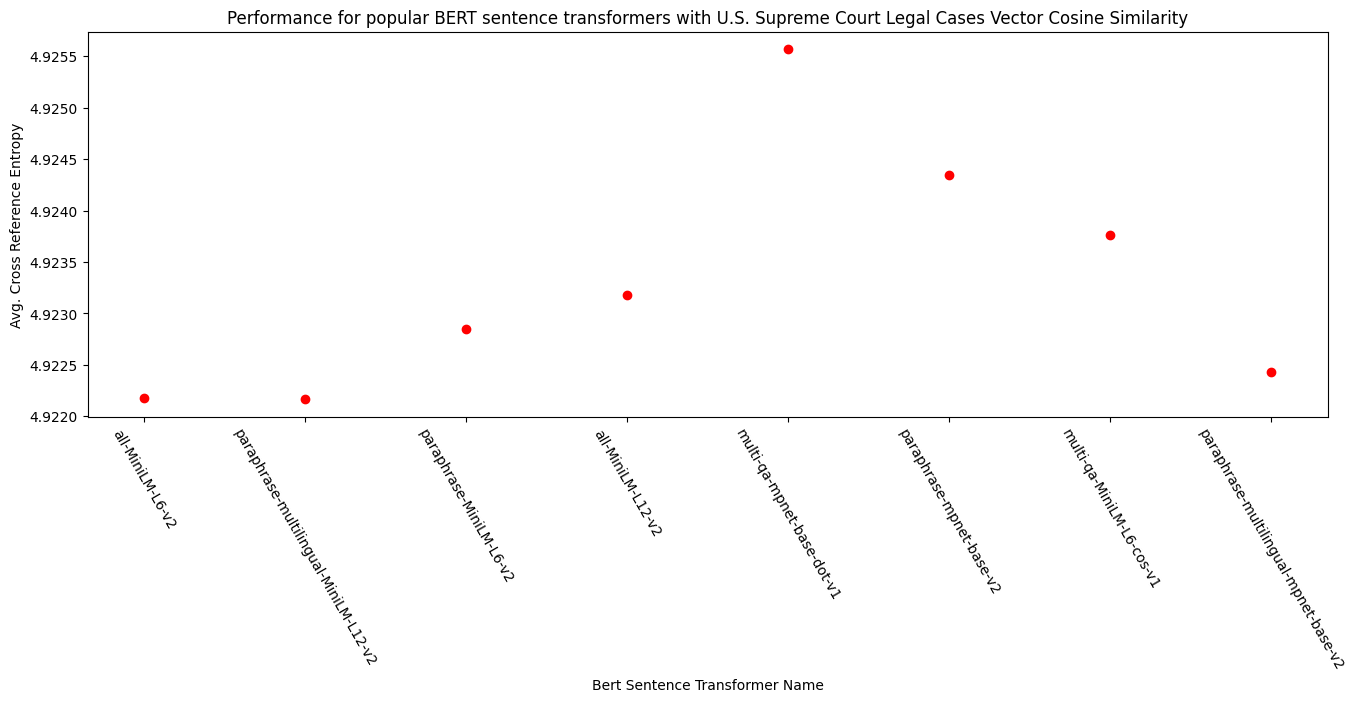

In [200]:
fig = plt.figure(figsize = (16, 5))
plt.plot(bert_models, results, 'ro')
plt.xticks(rotation=-60)
plt.xlabel("Bert Sentence Transformer Name")
plt.ylabel("Avg. Cross Reference Entropy")
plt.title("Performance for popular BERT sentence transformers with U.S. Supreme Court Legal Cases Vector Cosine Similarity")
plt.show()

AttributeError: 'list' object has no attribute 'bar'

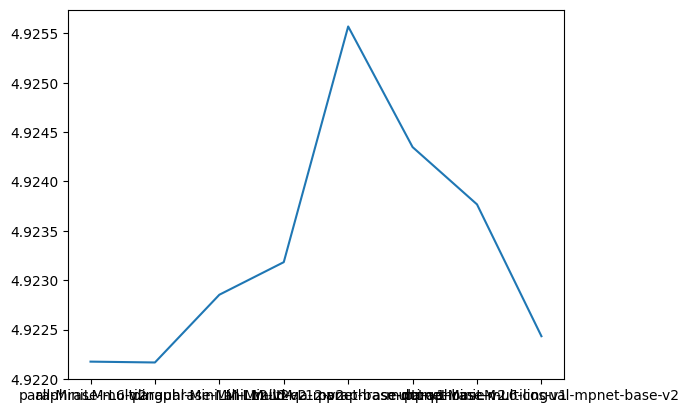

In [187]:
plt.plot(bert_models,results).bar()

In [173]:
getAvgEntropyOfModel("all-MiniLM-L6-v2")

4.922175

In [174]:
getAvgEntropyOfModel("paraphrase-multilingual-MiniLM-L12-v2")

Downloading:   0%|          | 0.00/968 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/645 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

4.9221663

In [175]:
getAvgEntropyOfModel("paraphrase-MiniLM-L6-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

4.9228525

In [176]:
getAvgEntropyOfModel("all-MiniLM-L12-v2")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

4.9231825

In [177]:
getAvgEntropyOfModel("multi-qa-mpnet-base-dot-v1")

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

4.9255695

In [178]:
getAvgEntropyOfModel("paraphrase-mpnet-base-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

4.924348

In [179]:
getAvgEntropyOfModel("multi-qa-MiniLM-L6-cos-v1")

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

4.9237676

In [180]:
getAvgEntropyOfModel("paraphrase-multilingual-mpnet-base-v2")

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/723 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/402 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

4.9224324

In [198]:
model = SentenceTransformer('all-MiniLM-L6-v2')
def bert_similarity(X,case_id):
    sentences = X
    sentence_embeddings = model.encode(sentences)
    
    query = sentences[case_id]
    query_embedding = model.encode(query)

    # Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
    number_top_matches = 5
    similar_sentences = cosine_similarity([query_embedding], sentence_embeddings)[0].argsort()[::-1][1:number_top_matches+1]
    print(similar_sentences)

    return sentence_embeddings

In [199]:
print("BERT \nFinal Text")
text_vec = bert_similarity(df['Text'], 2)

print("Summary Pipeline")
transformer_vec = bert_similarity(df['summary_pipeline'], 2)

print("Summary Summa")
summa_vector = bert_similarity(df['summary_summa'], 2)

print("Concatenated Vectors")
bert_vectors = combined_vectors(text_vec, transformer_vec, summa_vector)

print(bert_vectors.shape)

BERT 
Final Text
[ 16   8 113  96 116]
Summary Pipeline
[38 68 16 13 45]
Summary Summa
[120  52 131  16  64]
Concatenated Vectors
(139, 384)
(139, 1152)


## Word2Vec

In [115]:
def train_word2vec(X):
    model = Word2Vec(X, vector_size=100, window=5, min_count=1, workers=4)  
    return model



In [132]:
sentences = df['final_text'].apply(lambda x: x.split(" "))
w2v_model = train_word2vec(sentences)

In [134]:
# len(w2v_model.wv.index_to_key)
w2v_model.wv.most_similar('supreme')

[('decision', 0.998510479927063),
 ('sixth', 0.9983252286911011),
 ('writ', 0.9982919096946716),
 ('circuit', 0.9981789588928223),
 ('jurisdiction', 0.9979424476623535),
 ('preliminary', 0.9979386925697327),
 ('reverse', 0.9979249835014343),
 ('grant', 0.9978001117706299),
 ('petition', 0.9977887272834778),
 ('federal', 0.9977492690086365)]

In [46]:
#save df["text"][0] as a text file
with open("check.txt", "w") as text_file:
    text_file.write(df["Text"][0])